# Dynamic recalibration of DTS observations using "raw" observations

Part of the "VertHarpExp2017Kloendeel" (Vertical Harp Spectral Response Kloendeel Experiment; Testing the spectral response of the two DTS instruments (Ultima and XT) against the Licor Eddy Covariance observations made as part of the Micrometeorology Summer School, Kloendeel 2017

In [1]:
# netcdf/numpy/xray/stats
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import xarray as xr
from scipy.stats.stats import pearsonr

# OS interaction
import sys
import pickle
import os

# import plotting
import seaborn as sns
import matplotlib
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import kgraph

# Offline Turbulence Package
import turbpy

# Customize
sns.set_style("whitegrid")
sns.set_context('talk')
%matplotlib inline

# XML
import xmltodict

In [2]:
# --------------------------------------------------------------------------------------------------------------------
# Directory Lists
# Unix
if 'linux' in sys.platform:
    dirPre = '/home/lapok/gdrive/DarkMix/'
# Mac
elif 'darwin' in sys.platform:
    dirPre = '/Users/karllapo/gdrive/DarkMix/'

dirData = dirPre + 'proj/exampleDTS/data/VertHarpExp2017Kloendeel/UltimaVHSRE'
dirPrint = dirPre + 'graphics'
dirProcessed = dirPre + 'proj/exampleDTS/data/VertHarpExp2017Kloendeel/processed'

## Location library for labeling

In [3]:
def labelLocation(ds):

    location = {
        ########################
        ## Near vertical harp ##
        ########################
        # Segment 1, up and over ~ 47.3 to 50.8. 2m vertical separation,
        # tentatively assign 47.3 to 48.5 as the upward limb.
        'vertHarpNear_1': [47.3, 48.5],
        # Segment 2, up and over ~ 47.3 to 50.8. 2m vertical separation,
        # tentatively assign 50.8 to 49.3 as the downward limb.
        'vertHarpNear_2': [49.3, 50.8],
        # Segment 3, up and over ~ 51.5 to 54.9. 2m vertical separation,
        # tentatively assign 51.5 to 53.0 as the upward limb.
        'vertHarpNear_3': [51.5, 53.0],
        # Segment 4, up and over ~ 51.5 to 54.9. 2m vertical separation,
        # tentatively assign 53.4 to 54.9 as the downward limb.
        'vertHarpNear_4': [53.4, 54.9],

        #######################
        ## Far vertical harp ##
        #######################
        # Segment 1, up and over ~ 326.2 to 329.75. 2m vertical separation,
        # tentatively assign 326.2 to 327.7 as the upward limb.
        'vertHarpFar_1': [326.2, 327.7],
        # Segment 2, up and over ~ 326.2 to 329.75. 2m vertical separation,
        # tentatively assign 329.75 to 328.25 as the downward limb.
        'vertHarpFar_2': [328.25, 329.75],
        # Segment 3, up and over ~ 330.4 to 333.75. 2m vertical separation,
        # tentatively assign 330.4 to 331.9 as the upward limb.
        'vertHarpFar_3': [330.4, 331.9],
        # Segment 4, up and over ~ 330.4 to 333.75. 2m vertical separation,
        # tentatively assign 332.25 to 333.75 as the downward limb.
        'vertHarpFar_4': [332.25, 333.75],


        ######################
        ## Horizontal Array ##
        ######################
        'Horizontal - 86cm': [245, 294.5],
        'Horizontal - 84cm': [192.25, 242],
        'Horizontal - 60.5cm': [136, 185.5],
        'Horizontal - 56cm': [82.5, 132],

        #######################
        ## Temperature Baths ##
        #######################
        'warmBathNear': [29, 34],
        'coldBathNear': [17, 22],
        'warmBathFar': [346, 351],
        'coldBathFar': [357, 362],
    }

    # Assign location tags
    ds.coords['location'] = (('LAF'), [None] * ds.LAF.size)
    ds.attrs['locations'] = ';'.join(list(location.keys()))
    for l in location:
        ds.coords['location'].loc[(ds.LAF > location[l][0]) & (ds.LAF < location[l][-1])] = l

    # Assign height values
    locationHeights = {
        'Horizontal - 86cm': 0.86,
        'Horizontal - 84cm': 0.84,
        'Horizontal - 60.5cm': 0.605,
        'Horizontal - 56cm': 0.56,
    }

    return(ds)

In [4]:
def readDumbXMLFiles(dumbXMLFile):
    with open(dumbXMLFile) as dumb:
        doc = xmltodict.parse(dumb.read())
    
    # Remove all of the bullshit
    doc = doc['logs']['log']
    
    # Extract units/metadata info out of xml dictionary
    metaData = {'LAF_beg': float(doc['startIndex']['#text']),
                'LAF_end': float(doc['endIndex']['#text']),
                'dLAF': float(doc['stepIncrement']['#text']),
                'dt_start': pd.to_datetime(doc['startDateTimeIndex'], infer_datetime_format=True),
                'dt_end': pd.to_datetime(doc['endDateTimeIndex'], infer_datetime_format=True),
                'probe1Temperature': float(doc['customData']['probe1Temperature']['#text']),
                'probe2Temperature': float(doc['customData']['probe2Temperature']['#text']),
                'fiberOK': int(doc['customData']['fibreStatusOk']),
               }

    # Extract data
    data = doc['logData']['data']

    numEntries = np.size(data)
    LAF = np.empty(numEntries)
    Ps = np.empty_like(LAF)
    Pas = np.empty_like(LAF)
    temp = np.empty_like(LAF)

    for dnum, dlist in enumerate(data):
        LAF[dnum], Ps[dnum], Pas[dnum], temp[dnum] = list(map(float, dlist.split(',')))

    actualData = pd.DataFrame.from_dict({'LAF': LAF, 'Ps': Ps, 'Pas': Pas, 'temp': temp}).set_index('LAF')
    
    
    return(actualData, metaData)

# List of files to iterate over
os.chdir(dirData)
dirCon = [dC for dC in os.listdir() if 'channel 1' in dC]
nTotal = np.size(dirCon)
ds = None

for nDumb, someDumbFiles in enumerate(dirCon):
    if '.xml' in someDumbFiles:
        print("\r", someDumbFiles + 'File ' + str(nDumb) + ' of ' + str(nTotal), end="")
    else:
        continue

    # Read the file
    df, meta = readDumbXMLFiles(someDumbFiles)
    
    # Create a temporary xarray Dataset
    temp_Dataset = xr.Dataset.from_dataframe(df)
    temp_Dataset.coords['time'] = meta['dt_start']
    temp_Dataset['probe1Temperature'] = meta['probe1Temperature']
    temp_Dataset['probe2Temperature'] = meta['probe2Temperature']
    temp_Dataset['fiberStatus'] = meta['fiberOK']
    
    if ds:
        ds = xr.concat([ds, temp_Dataset], dim='time')
    else:
        ds = temp_Dataset

    # Chunking/saving to avoid lock-up
    if np.mod(nDumb + 1, 1000) == 0:
        os.chdir(dirProcessed)
        numChunk = np.floor_divide(nDumb, 1000)
        ds.attrs = {'LAF_beg': meta['LAF_beg'],
                    'LAF_end': meta['LAF_end'],
                    'dLAF': meta['dLAF']}
        ds = labelLocation(ds)
        ds.to_netcdf('VHRSE_chunk' + str(numChunk) + '.nc', 'w')
        ds.close()
        ds = None
        os.chdir(dirData)


 channel 1_20170904234741911.xmlFile 16382 of 16383

In [5]:
#########################
## Load processed data ##
#########################
os.chdir(dirProcessed)
ds = xr.open_mfdataset('VHRSE_chunk0.nc')
ds.attrs['locations'] = ds.attrs['locations'].split(';')
print(ds)
print(np.unique(ds.attrs['locations']))

<xarray.Dataset>
Dimensions:            (LAF: 4193, time: 1000)
Coordinates:
  * LAF                (LAF) float64 -83.06 -82.93 -82.8 -82.67 -82.55 ...
  * time               (time) datetime64[ns] 2017-09-04T17:29:38 ...
    location           (LAF) object '' '' '' '' '' '' '' '' '' '' '' '' '' ...
Data variables:
    Pas                (time, LAF) float64 0.1196 -0.9827 13.01 -1.58 -9.542 ...
    Ps                 (time, LAF) float64 -0.7304 1.216 -0.9891 2.12 -11.28 ...
    temp               (time, LAF) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    probe1Temperature  (time) float64 44.38 44.37 44.37 44.37 44.37 44.37 ...
    probe2Temperature  (time) float64 10.88 10.88 10.89 10.88 10.89 10.88 ...
    fiberStatus        (time) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Attributes:
    LAF_beg:    -83.055
    dLAF:       0.127
    LAF_end:    449.746
    locations:  ['vertHarpNear_1', 'Horizontal - 84cm', 'Horizontal - 86cm', ...
['Horizontal - 56cm' 'Horizontal - 60.5cm' '

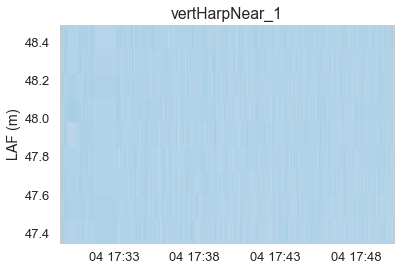

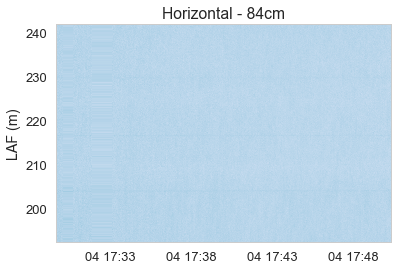

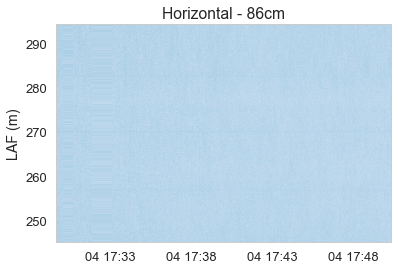

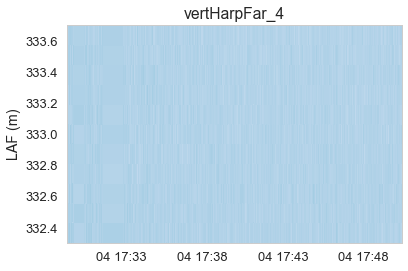

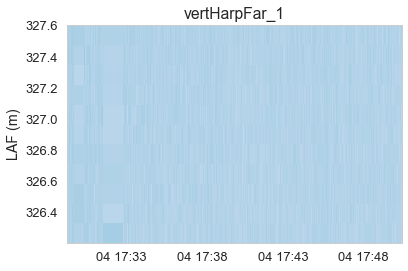

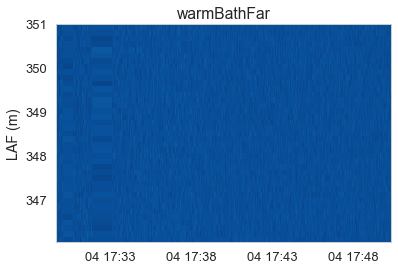

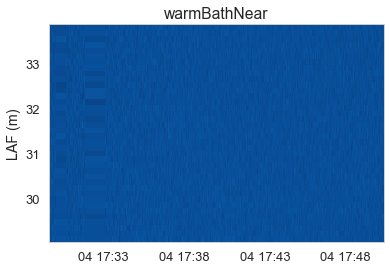

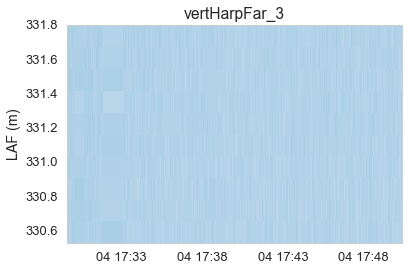

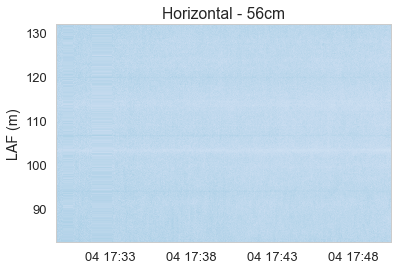

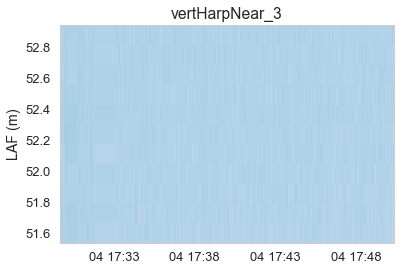

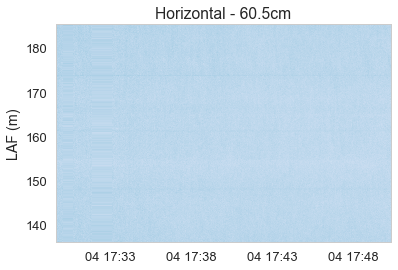

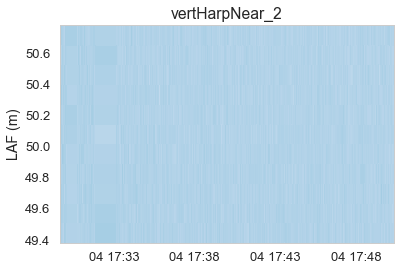

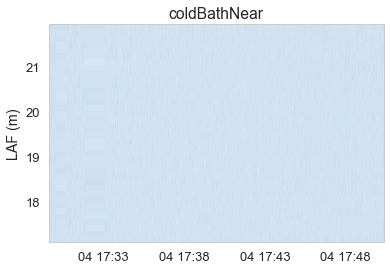

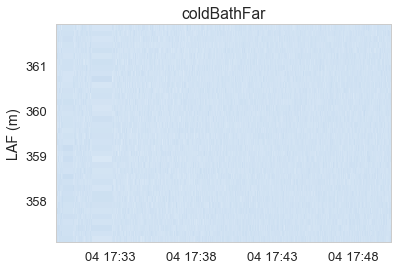

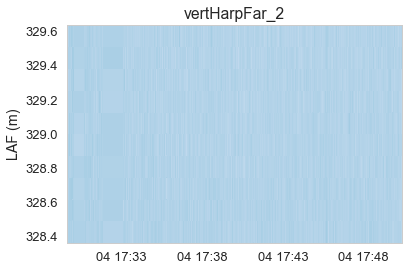

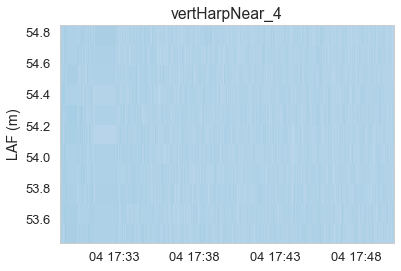

In [6]:
for loc in ds.attrs['locations']:
    
    # Image of data for each section
    fig, ax = plt.subplots(1, 1)
    temp_ds = ds.temp.swap_dims({'LAF': 'location'}).sel(location=loc)
    H = np.ma.masked_array(temp_ds.values, np.isnan(temp_ds))
    t = temp_ds.time.values
    length = temp_ds.LAF.values
    X, Y = np.meshgrid(t, length)

    ax.pcolormesh(X.T, Y.T, H, cmap=cm.Blues, vmin=0, vmax=50)
    ax.set_title(loc)
    ax.set_ylabel('LAF (m)')

In [7]:
def calibrationDTS(refTemps, dts_ds, refNames):

# Reference temperatures
T_input = [22, 62.5, 22]
T1 = T_input[0]
T2 = T_input[1]
T3 = T_input[2]

# Reference sections
z_input = [18, 350, 377]
z1 = z_input[0]
z2 = z_input[1]
z3 = z_input[2]

# Amplitudes of stokes/anti-stokes
P_antistokes_input = [3200, 3000, 2275]
P_antistokes_z1 = P_antistokes_input[0]
P_antistokes_z2 = P_antistokes_input[1]
P_antistokes_z3 = P_antistokes_input[2]

P_stokes_input = [3250, 2500, 2350]
P_stokes_z1 = P_stokes_input[0]
P_stokes_z2 = P_stokes_input[1]
P_stokes_z3 = P_stokes_input[2]

# A matrix
A = [[1, -T1, T1*z1],
     [1, -T2, T2*z2],
     [1, -T3, T3*z3],
    ]

# b matrix
b = [[T1 * np.log(P_stokes_z1 / P_antistokes_z1)],
     [T2 * np.log(P_stokes_z2 / P_antistokes_z2)],
     [T3 * np.log(P_stokes_z3 / P_antistokes_z3)],
    ]

x = np.linalg.solve(A, b)

IndentationError: expected an indented block (<ipython-input-7-639343cb101a>, line 4)

In [ ]:
print(x)